In [1]:
import pandas as pd
import os
from matplotlib.colors import LinearSegmentedColormap
#from highlight_text import ax_text, fig_text
#from mplsoccer import VerticalPitch, Pitch
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

from joblib import Parallel, delayed
from tqdm import tqdm

Se trabajará con 2 set de datos: 1 de Eventos y 1 de los resultados de los partidos.

In [28]:
path_events = 'Data/Premier/ENG-Premier LeagueWhoScoredTeamNumMatches15Spatial4x4TimeDiv45.csv'
path_matches = 'Data/Premier/procesated_matches_PL_last_5_seasons.csv'

events = pd.read_csv(path_events) 
matches = pd.read_csv(path_matches)

In [29]:
matches.tail()

,number_of_match,team_home,team_away,score_home,score_away,score_prom_home,score_prom_away,posession_home,posession_away,total_shots_home,...,points_away,streak_home,streak_away,wins_in_last_5_matches_home,wins_in_last_5_matches_away,ties_in_last_5_matches_home,ties_in_last_5_matches_away,losses_in_last_5_matches_home,losses_in_last_5_matches_away,result
1639,129,Everton,Manchester United,0.0,3.0,1.181818,1.083333,41.636364,54.250000,14.272727,...,21,2,2,3,4,0,0,2,1,2
1640,130,Fulham,Wolverhampton,3.0,2.0,0.833333,1.333333,48.750000,47.833333,11.083333,...,15,0,1,1,2,1,2,3,1,1
1641,131,Arsenal,Wolverhampton,2.0,1.0,2.076923,1.384615,61.230769,47.230769,14.538462,...,15,2,0,3,2,1,1,1,2,1
1642,132,Brentford,Luton Town,3.0,1.0,1.461538,0.923077,46.923077,35.769231,14.153846,...,9,0,1,3,1,0,2,2,2,1
1643,147,Aston Villa,Manchester City,1.0,0.0,2.384615,2.538462,52.538462,62.384615,14.923077,...,29,2,5,4,3,0,2,1,0,1


Filtramos desde la temporada 2019-2020.

In [31]:
events = events[events['Date'] > '2019-08-01']
events.head()

,Unnamed: 0,Team,Date,Goals,Number_matches,game_id,Pass_Successful_bin_0_time_0-45,Pass_Unsuccessful_bin_0_time_0-45,Pass_Successful_bin_1_time_0-45,Pass_Unsuccessful_bin_1_time_0-45,...,Error_Successful_bin_11_time_45-90,Error_Unsuccessful_bin_11_time_45-90,Error_Successful_bin_12_time_45-90,Error_Unsuccessful_bin_12_time_45-90,Error_Successful_bin_13_time_45-90,Error_Unsuccessful_bin_13_time_45-90,Error_Successful_bin_14_time_45-90,Error_Unsuccessful_bin_14_time_45-90,Error_Successful_bin_15_time_45-90,Error_Unsuccessful_bin_15_time_45-90
6840,0,Norwich,2019-08-09,2,15,1375927,37.0,42.0,161.0,95.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6841,0,Liverpool,2019-08-09,3,15,1375927,82.0,16.0,319.0,72.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6842,0,Man City,2019-08-10,5,15,1375928,77.0,17.0,301.0,34.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6843,0,West Ham,2019-08-10,0,15,1375928,58.0,25.0,331.0,54.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6844,0,Sheff Utd,2019-08-10,1,0,1375929,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


La primera columna no dice nada, la eliminamos.

In [32]:
events = events.drop(columns = ['Unnamed: 0'])
events.head()

,Team,Date,Goals,Number_matches,game_id,Pass_Successful_bin_0_time_0-45,Pass_Unsuccessful_bin_0_time_0-45,Pass_Successful_bin_1_time_0-45,Pass_Unsuccessful_bin_1_time_0-45,Pass_Successful_bin_2_time_0-45,...,Error_Successful_bin_11_time_45-90,Error_Unsuccessful_bin_11_time_45-90,Error_Successful_bin_12_time_45-90,Error_Unsuccessful_bin_12_time_45-90,Error_Successful_bin_13_time_45-90,Error_Unsuccessful_bin_13_time_45-90,Error_Successful_bin_14_time_45-90,Error_Unsuccessful_bin_14_time_45-90,Error_Successful_bin_15_time_45-90,Error_Unsuccessful_bin_15_time_45-90
6840,Norwich,2019-08-09,2,15,1375927,37.0,42.0,161.0,95.0,228.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6841,Liverpool,2019-08-09,3,15,1375927,82.0,16.0,319.0,72.0,490.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6842,Man City,2019-08-10,5,15,1375928,77.0,17.0,301.0,34.0,729.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6843,West Ham,2019-08-10,0,15,1375928,58.0,25.0,331.0,54.0,388.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6844,Sheff Utd,2019-08-10,1,0,1375929,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#

In [15]:
matches = matches.reset_index()
X = matches.to_numpy()
scaler = preprocessing.StandardScaler()
X_escalados = scaler.fit_transform(X)
y = result

In [16]:
y.unique()

array([2, 1, 0])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_escalados, y, test_size=0.3, random_state = 1, stratify=y)

In [18]:
clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-3),
    scheduler_params={"step_size":50,
                        "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='entmax', # "sparsemax" "entmax"
    )
    
clf.fit(X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    eval_name=['train', 'valid'], 
    eval_metric=['accuracy'], 
    max_epochs=1000 , patience=100, 
    batch_size=28, drop_last=False)

pred = clf.predict(X_test)

/Users/gustavofernandez/Desktop/iPre-resultados-deportivos/env/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


ValueError: Input contains NaN.

: 

# Modelo 1: Regresión Logística

In [ ]:
from sklearn.linear_model import LogisticRegression

logistic_reg = LogisticRegression(max_iter = 1000)
logistic_reg.fit(X_train, y_train)

predicted_logistic_reg = logistic_reg.predict(X_test)
print("Clasification report")
print(classification_report(y_test, predicted_logistic_reg))

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


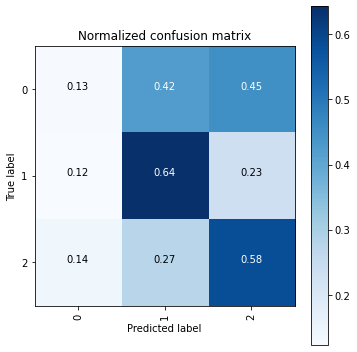

In [ ]:
cnf_matrix = confusion_matrix(y_test, predicted_logistic_reg)
np.set_printoptions(precision=2)
classes = np.unique(y)
# Plot normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True, title='Normalized confusion matrix')

plt.show()

## SVM

In [ ]:
from sklearn.svm import SVC

kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in kernels:
    svm = SVC(kernel = kernel)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        f"For kernel = {kernel}, the accuracy is: {acc}"
    )


For kernel = linear, the accuracy is: 0.48232848232848236


MemoryError: Unable to allocate 2.76 GiB for an array with shape (3367, 109824) and data type float64

In [ ]:
from sklearn.svm import SVC

svm = SVC(kernel = "rbf")

svm.fit(X_train, y_train)

predicted_svm = svm.predict(X_test)
print("Clasification report")
print(classification_report(y_test, predicted_svm))

Clasification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       161
           1       0.53      0.71      0.61       277
           2       0.52      0.65      0.57       264

    accuracy                           0.52       702
   macro avg       0.35      0.45      0.39       702
weighted avg       0.40      0.52      0.46       702



Normalized confusion matrix


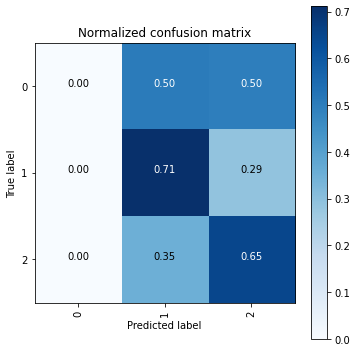

In [ ]:
cnf_matrix = confusion_matrix(y_test, predicted_svm)
np.set_printoptions(precision=2)
# Plot normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True, title='Normalized confusion matrix')

plt.show()